In [1]:
import numpy as np
import sys
from matplotlib import pyplot as plt
import pandas as pd
from scipy import stats
from scipy import interpolate

sys.path.insert(1, '/mnt/Files/EuclidAGN/')
sys.path.insert(1, '../lib/')
from AGNCatalogToolbox import main as AGN
from VelocityDispersionLibrary import FullVelocityDispersion

In [2]:
# Dark Matter
data_path = "/mnt/Files/Astronomy/MultiDark/npy_files/MD_0.987.npy"
data = np.load(data_path)

cut = 100

print("Original Length: ", len(data), "/8 =", len(data)/8)

data = data[(data['x'] < cut) * (data['y'] < cut) * (data['z'] < cut)]

print("New Length: ", len(data))



#length = int(np.floor(len(data)/2))

#print(length)

#data = data[:length]

Original Length:  141476598 /8 = 17684574.75
New Length:  112865


In [3]:
# SDSS
df = pd.read_csv("/mnt/Files/Astronomy/SDSS/Catalog_SDSS_complete.dat", sep = ' ')

# Grab useful fields
SersicIndex = np.array(df['n_bulge'])
StellarMass = np.array(df['MsCent'])
VMax = np.array(df["Vmaxwt"])
Re = np.array(df["logReSerExp"])


# Create flags to remove offending galaxies
flag_central = df["NewLCentSat"] == 1. # Only centrals
flag_hasMass = StellarMass != -999. # Only valid stellar masses
flag_is8 = SersicIndex != 8. # Cap
flag_is0 = SersicIndex != 0.1
flag_morph = np.array(df["TType"]) < 0.
flag_combined = flag_hasMass & flag_is8 & flag_is0 & flag_central & flag_morph

df = None
flag_central = None
flag_hasMass = None
flag_is8 = None
flag_is0 = None
flag_morph = None


# Remove galaxies
StellarMass = StellarMass[flag_combined]
SersicIndex = SersicIndex[flag_combined]
Size = 10**Re[flag_combined]
VMax = VMax[flag_combined]


# Bin by sm
bins = np.arange(0., 30.0, 0.05)

# Weighted average by VMax
array, edges, numbers = stats.binned_statistic(StellarMass, VMax*Size, statistic = 'sum', bins = bins)
den = stats.binned_statistic(StellarMass, VMax, statistic = 'sum', bins = bins)[0]
array = array/den # Calculate the numerator and denominator separately, to make the best use of binned statistic

# For the purposes of the error, we need to do some housekeeping here
means = np.zeros(len(numbers)) # Storage array for the means - the value of the mean at each element
for i in range(len(means)):
    means[i] = array[numbers[i]-1] # There probably is a faster way to do this
# Calculate the components needed for the standard deviation
std_wrong = stats.binned_statistic(StellarMass, VMax*(Size - means)**2, statistic = 'sum', bins = bins)[0]
binCounts = stats.binned_statistic(StellarMass, means, statistic = 'count', bins = bins)[0]
# Calculate the standard deviation
dev = np.sqrt(std_wrong/(((binCounts-1)/binCounts)*den))

get_Size = interpolate.interp1d(bins[0:-1], array)
get_size_Error = interpolate.interp1d(bins[0:-1], dev)


/home/chris/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide
/home/chris/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/home/chris/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in multiply
/home/chris/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


In [4]:
sm = AGN.halo_mass_to_stellar_mass(np.log10(data['mvir']/0.69), 0.0)

data = None

Scatter is a thing, valued at 0.11


In [5]:
def sizes_ric_nat(sm):
    return (10**-0.314) * ((10*sm)*0.042) * (1 + (10**sm)/(10**10.537))**0.76

def sizes_FS(sm):
    return 0.1 * ((10**sm)**0.14) * ((1 + (10**sm)/(3.98e10))) ** (0.39-0.14)


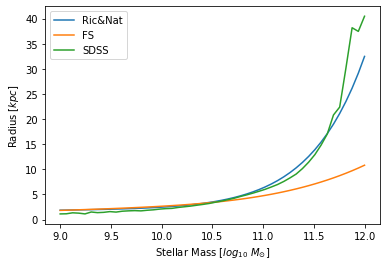

In [6]:
plt.figure()
sm_range = np.linspace(9, 12)
plt.plot(sm_range, sizes_ric_nat(sm_range), label = "Ric&Nat")
plt.plot(sm_range, sizes_FS(sm_range), label = "FS")
plt.plot(sm_range, get_Size(sm_range), label = "SDSS" )
plt.xlabel("Stellar Mass [$log_{10}$ $M_{\odot}$]")
plt.ylabel("Radius [$kpc$]")
plt.legend()
plt.show()


In [7]:

# Bin up the SDSS
bins = np.arange(0.0, 30.0, 0.05)
# Weighted average by VMax
array, edges, numbers = stats.binned_statistic(StellarMass, VMax*SersicIndex, statistic = 'sum', bins = bins)
den = stats.binned_statistic(StellarMass, VMax, statistic = 'sum', bins = bins)[0]
array = array/den # Calculate the numerator and denominator separately, to make the best use of binned statistic

# For the purposes of the error, we need to do some housekeeping here
means = np.zeros(len(numbers)) # Storage array for the means - the value of the mean at each element
for i in range(len(means)):
    means[i] = array[numbers[i]-1] # There probably is a faster way to do this
# Calculate the components needed for the standard deviation
std_wrong = stats.binned_statistic(StellarMass, VMax*(SersicIndex - means)**2, statistic = 'sum', bins = bins)[0]
binCounts = stats.binned_statistic(StellarMass, means, statistic = 'count', bins = bins)[0]
# Calculate the standard deviation
dev = np.sqrt(std_wrong/(((binCounts-1)/binCounts)*den))

get_SersicIndex = interpolate.interp1d(bins[0:-1], array)

get_Error = interpolate.interp1d(bins[0:-1], dev)


/home/chris/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/home/chris/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/home/chris/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()
/home/chris/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


In [8]:
sm_range = np.linspace(0, 12)
n_test = get_SersicIndex(sm_range)
n_error = get_Error(sm_range)

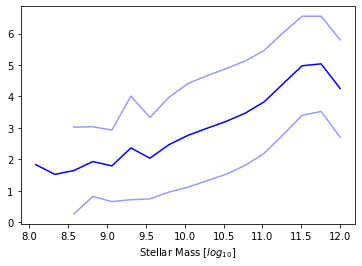

In [9]:
plt.figure()
plt.plot(sm_range, n_test, color = 'b')
plt.plot(sm_range, n_test + n_error, color = 'b', alpha = 0.4)
plt.plot(sm_range, n_test - n_error, color = 'b', alpha = 0.4)
plt.xlabel("Stellar Mass [$log_{10}$]" )
plt.show()

In [ ]:
stellarMasses = sm
sm = None
sizes = sizes_ric_nat(stellarMasses)

print(len(stellarMasses))

sersicIndexes = get_SersicIndex(stellarMasses)
sersicIndexes[stellarMasses < 9] = 2.0

Aperture = np.ones_like(stellarMasses) * 0.5
Beta = np.random.normal(0.15, 0.12, size=len(stellarMasses))
HaloRs = 20 * sizes
HaloC = np.ones_like(stellarMasses) * 15
om = 0.27
H = 67.66

VD = FullVelocityDispersion(Aperture, Beta, sizes, sersicIndexes, 10**stellarMasses, HaloRs, HaloC, om, H)

112865
Reserving Memory
Reserving restypes
Arrays defined, entering c section
